In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [51]:
TRAIN_PATH = './data/train.csv'
df = pd.read_csv(TRAIN_PATH)

## Feature Engineering

In [52]:
def full_feature_engineering(df):
    new_df = df.copy()
    new_df['Height'] = np.abs(new_df['Y_Maximum'] - new_df['Y_Minimum'])
    new_df['Width'] = np.abs(new_df['X_Maximum'] - new_df['X_Minimum'])
    new_df[['Log_Outside_X_Index', 
            'Log_X_Perimeter', 'Log_Y_Perimeter']] = np.log(new_df[['Outside_X_Index', 
                                                                    'X_Perimeter', 'Y_Perimeter']] + 1e-6)
    new_df[['Log_Width', 'Log_Height']] = np.log(new_df[['Width', 'Height']] + 1)
    new_df['Abs_Orientation'] = np.abs(new_df['Orientation_Index'])
    new_df['Log_Range'] = np.log(1 + new_df['Maximum_of_Luminosity']) - np.log(1 + new_df['Minimum_of_Luminosity'])
    new_df['Log_Lum'] = np.log(new_df['Sum_of_Luminosity'])
    new_df['Log_Avg_Lum'] = new_df['Log_Lum'] - 2 * new_df['LogOfAreas']

    y_cols = ['Pastry', 'Z_Scratch', 'K_Scatch',
              'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
    non_cols = ['id'] + y_cols
    
    X = new_df.drop(columns=non_cols)
    X_stats = X.describe().T
    X = (X - X_stats['mean']) / X_stats['std']
    pca = PCA().fit(X)
    new_df[[f'pca_{i}' for i in range(pca.n_components_)]] = pca.transform(X)

    new_df['No Defect'] = (new_df[y_cols].sum(axis=1) == 0).astype('int')

    drop_cols = ['Y_Maximum', 'Y_Minimum', 'X_Maximum', 'X_Minimum']
    return new_df.drop(columns=drop_cols)

In [53]:
train_df = full_feature_engineering(df)
y_cols = ['No Defect', 'Pastry', 'Z_Scratch', 'K_Scatch',
          'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
y = train_df[y_cols]
X = train_df.drop(y, axis=1)
ids = X['id']
X = X.drop(['id'], axis=1)

In [54]:
gkf = GroupKFold(n_splits=5)

trains = []
valids = []
for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, ids)):
    print(f'Fold: {fold}')
    train_X = X.loc[train_index]
    train_y = y.loc[train_index]
    valid_X = X.loc[valid_index]
    valid_y = y.loc[valid_index]
    trains.append((train_X, train_y))
    valids.append((valid_X, valid_y))

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


## XGB

In [55]:
estimators = 1000
stopping = 5
lr = 0.05

xgboosts = []
aucs = np.zeros(8)

for fold in range(5):
    print(f'Fold: {fold}')

    X, y = trains[fold]
    Xv, yv = valids[fold]

    # Fit Model
    model = XGBClassifier(n_estimators=estimators,
                          early_stopping_rounds=stopping,
                          learning_rate=lr,
                          n_jobs=-1,
                          subsample=0.8
                          )
    model.fit(X, y, eval_set=[(Xv, yv)], verbose=0)
    xgboosts.append(model)

    # Calculate AUROCs
    preds = model.predict_proba(Xv)
    aucs += np.array(roc_auc_score(yv, preds, multi_class='ovr', average=None))
    
val_aucs = pd.Series(aucs, index=y_cols)/5
display(val_aucs)
essential_aucs = val_aucs.drop(index='No Defect')
print(f'Mean AUC of 7: {essential_aucs.mean():.4f}')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


No Defect       0.639757
Pastry          0.867205
Z_Scratch       0.957473
K_Scatch        0.984751
Stains          0.991365
Dirtiness       0.877124
Bumps           0.802708
Other_Faults    0.699451
dtype: float64

Mean AUC of 7: 0.8829


In [56]:
importances = xgboosts[0].feature_importances_
for xgboost in xgboosts[1:]:
    importances += xgboost.feature_importances_
importances = np.array(importances) / 5
Xcols = np.array(X.columns)[np.argsort(importances)][::-1]
sortd = np.sort(importances)[::-1]
for i, col in enumerate(Xcols):
    print(f'{col}: {sortd[i]:.2f}')

pca_0: 0.22
LogOfAreas: 0.08
TypeOfSteel_A300: 0.08
Pixels_Areas: 0.04
Steel_Plate_Thickness: 0.03
Orientation_Index: 0.03
Outside_X_Index: 0.03
Length_of_Conveyer: 0.02
Y_Perimeter: 0.02
Width: 0.02
Edges_Y_Index: 0.02
pca_1: 0.02
Log_Y_Index: 0.02
pca_2: 0.02
Outside_Global_Index: 0.01
Abs_Orientation: 0.01
Log_Range: 0.01
pca_8: 0.01
TypeOfSteel_A400: 0.01
Edges_Index: 0.01
Minimum_of_Luminosity: 0.01
Maximum_of_Luminosity: 0.01
X_Perimeter: 0.01
Log_X_Index: 0.01
pca_9: 0.01
pca_7: 0.01
Square_Index: 0.01
pca_12: 0.01
Sum_of_Luminosity: 0.01
SigmoidOfAreas: 0.01
pca_22: 0.01
Luminosity_Index: 0.01
pca_11: 0.01
pca_13: 0.01
Edges_X_Index: 0.01
Empty_Index: 0.01
pca_6: 0.01
pca_21: 0.01
pca_10: 0.01
pca_5: 0.01
pca_31: 0.01
pca_14: 0.01
pca_34: 0.01
pca_19: 0.01
Log_Avg_Lum: 0.01
pca_29: 0.01
pca_18: 0.01
pca_4: 0.01
pca_20: 0.01
pca_24: 0.01
pca_37: 0.01
pca_36: 0.01
pca_35: 0.01
pca_23: 0.01
pca_15: 0.01
pca_27: 0.01
pca_32: 0.01
pca_17: 0.01
pca_16: 0.01
pca_28: 0.01
pca_25: 0.01


## RF

In [57]:
estimators = 500

rfs = []
aucs = np.zeros(8)

for fold in range(5):
    print(f'Fold: {fold}')

    # Fit Model
    model = RandomForestClassifier(n_estimators=estimators,
                                   n_jobs=-1,
                                   max_features=0.5)
    model.fit(*trains[fold])
    rfs.append(model)

    # Calculate AUROCs
    X_val, y_val = valids[fold]
    preds = np.array(model.predict_proba(X_val))[:,:,1].T
    aucs += np.array(roc_auc_score(y_val, preds,
                     multi_class='ovr', average=None))

val_aucs = pd.Series(aucs, index=y_cols)/5
display(val_aucs)
essential_aucs = val_aucs.drop(index='No Defect')
print(f'Mean AUC of 7: {essential_aucs.mean():.4f}')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


No Defect       0.648150
Pastry          0.862940
Z_Scratch       0.943396
K_Scatch        0.982931
Stains          0.991613
Dirtiness       0.880112
Bumps           0.796150
Other_Faults    0.683487
dtype: float64

Mean AUC of 7: 0.8772


In [58]:
importances = np.array(rfs[0].feature_importances_)
for rf in rfs[1:]:
    importances += rf.feature_importances_
importances = np.array(importances) / 5
Xcols = np.array(X.columns)[np.argsort(importances)][::-1]
sortd = np.sort(importances)[::-1]
for i, col in enumerate(Xcols):
    print(f'{col}: {sortd[i]:.2f}')

pca_0: 0.10
Outside_X_Index: 0.03
Log_Outside_X_Index: 0.03
Length_of_Conveyer: 0.02
Width: 0.02
Log_Width: 0.02
Steel_Plate_Thickness: 0.02
pca_9: 0.02
pca_7: 0.02
pca_2: 0.02
LogOfAreas: 0.02
pca_1: 0.02
Pixels_Areas: 0.02
Edges_Index: 0.02
pca_8: 0.02
Orientation_Index: 0.01
pca_11: 0.01
Log_Range: 0.01
Log_X_Index: 0.01
pca_13: 0.01
pca_6: 0.01
pca_12: 0.01
Empty_Index: 0.01
pca_4: 0.01
pca_14: 0.01
pca_25: 0.01
pca_5: 0.01
pca_31: 0.01
pca_30: 0.01
pca_3: 0.01
pca_28: 0.01
Luminosity_Index: 0.01
pca_33: 0.01
pca_10: 0.01
pca_23: 0.01
pca_24: 0.01
pca_15: 0.01
pca_27: 0.01
pca_22: 0.01
pca_18: 0.01
pca_16: 0.01
pca_32: 0.01
pca_34: 0.01
pca_17: 0.01
pca_26: 0.01
pca_36: 0.01
pca_35: 0.01
pca_29: 0.01
Log_Avg_Lum: 0.01
pca_21: 0.01
pca_19: 0.01
pca_20: 0.01
Minimum_of_Luminosity: 0.01
Edges_X_Index: 0.01
Edges_Y_Index: 0.01
SigmoidOfAreas: 0.01
Abs_Orientation: 0.01
Square_Index: 0.01
Log_Height: 0.01
Height: 0.01
Log_Lum: 0.01
Sum_of_Luminosity: 0.01
Maximum_of_Luminosity: 0.01
Log

## Basic Ensemble

Mean AUROC | RF Weight | XGB Weight
    0.8829 |    0.0    |    1.0
    0.8841 |    0.1    |    0.9
    0.8847 |    0.2    |    0.8
    0.8849 |    0.3    |    0.7
    0.8847 |    0.4    |    0.6
    0.8843 |    0.5    |    0.5
    0.8836 |    0.6    |    0.4
    0.8826 |    0.7    |    0.3
    0.8812 |    0.8    |    0.2
    0.8795 |    0.9    |    0.1
    0.8772 |    1.0    |    0.0


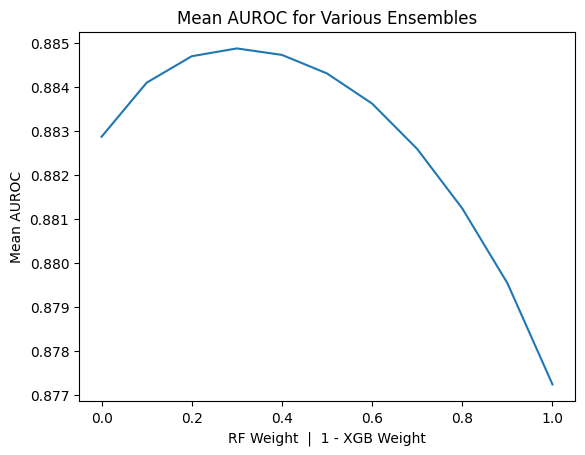

In [60]:
mean_aucs = []

print('Mean AUROC | RF Weight | XGB Weight')
print('='*36)
for i in range(11):
    rf_weight = i/10
    aucs = np.zeros(8)

    for fold in range(5):
        Xv, yv = valids[fold]

        # Calculate AUROCs
        xgb_preds = np.array(xgboosts[fold].predict_proba(Xv))
        rf_preds = np.array(rfs[fold].predict_proba(Xv))[:, :, 1].T

        preds = rf_weight * rf_preds + (1 - rf_weight) * xgb_preds
        aucs += np.array(roc_auc_score(yv, preds, multi_class='ovr', average=None))

    val_aucs = pd.Series(aucs, index=y_cols)/5
    essential_aucs = val_aucs.drop(index='No Defect')
    print(f'    {essential_aucs.mean():.4f} |    {i/10:.1f}    |    {1-i/10:.1f}')
    mean_aucs.append(essential_aucs.mean())

plt.plot(np.arange(0, 1.01, 0.1), mean_aucs)
plt.title('Mean AUROC for Various Ensembles')
plt.ylabel('Mean AUROC')
plt.xlabel('RF Weight  |  1 - XGB Weight')
plt.show()